<a href="https://colab.research.google.com/github/clysdid/BigContest_Advanced_2023/blob/master/0_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/예술의전당/after_cluster_data_for_statistic_2.csv")
df.head()

In [ ]:
df = df[['gender','tran_date','tran_time','play_date','play_st_time','ticket_cancel','performance_code','pre_open_date','open_date','genre','running_time','intermission','member_yn','play_weekday','play_weekend','membership_2','membership_1','pre_open_date_Y/N','play-preopen','segment','seg_type','cast_grade','crew_grade','host_grade','produce_grade','seat_count','seat_prefer','cluster','pay']]

In [ ]:
df.shape

(285877, 29)

# 변수 처리

In [ ]:
df.columns

In [ ]:
df.isnull().sum()

In [ ]:
df.gender.fillna('N',inplace=True)

In [ ]:
df.pre_open_date.fillna('N',inplace=True)

In [ ]:
df.genre.fillna('클래식',inplace=True)

In [ ]:
df.membership_2.fillna('N',inplace=True)

In [ ]:
df['play-preopen'].fillna(0,inplace=True)

In [ ]:
from datetime import datetime
import time

In [ ]:
def make_timedelta(date):
  try:
    return time.mktime(datetime.strptime(date,'%Y-%m-%d').timetuple())
  except:
    return 0

In [ ]:
df.head()

In [ ]:
df2 = df.copy()

In [ ]:
df2['tran_date'] = df2['tran_date'].apply(make_timedelta)

In [ ]:
df2['play_date'] = df2['play_date'].apply(make_timedelta)
df2['pre_open_date'] = df2['pre_open_date'].apply(make_timedelta)

In [ ]:
df2.head()

In [ ]:
import re

In [ ]:
def to_int(days):
  if days != 0:
    return int(re.search('\d+',days).group())
  else:
    return days


In [ ]:
df2['play-preopen'] = df2['play-preopen'].apply(to_int)

In [ ]:
df2.tail()

In [ ]:
df2.isnull().sum()

In [ ]:
gender_dummies = pd.get_dummies(df2.gender,prefix='gender')
code_dummies = pd.get_dummies(df2.performance_code,prefix='performance_code')
genre_dummies = pd.get_dummies(df2.genre,prefix='genre')
weekday_dummies = pd.get_dummies(df2.play_weekday,prefix='play_weekday')
membership2_dummies = pd.get_dummies(df2.membership_2,prefix='membership_2')
membership1_dummies = pd.get_dummies(df2.membership_1,prefix='membership_1')
segment_dummies = pd.get_dummies(df2.segment,prefix='segment')
seg_type_dummies = pd.get_dummies(df2.seg_type,prefix='seg_type')
cluster_dummies = pd.get_dummies(df2.cluster,prefix='cluster')

In [ ]:
def member_yn_label(yn):
  if yn == 'Y':
    return 1
  else:
    return 0

def play_weekday_label(day):
  if day == '평일':
    return 1
  else:
    return 0

In [ ]:
df2['member_yn'] = df2['member_yn'].apply(member_yn_label)
df2['play_weekend'] = df2['play_weekend'].apply(play_weekday_label)
df2['pre_open_date_Y/N'] = df2['pre_open_date_Y/N'].apply(member_yn_label)

In [ ]:
df3 = pd.concat([df2,gender_dummies,genre_dummies,membership2_dummies,membership1_dummies,segment_dummies,seg_type_dummies,cluster_dummies],axis=1)
df3.shape

(285877, 71)

In [ ]:
df3 = df3.drop(['gender','performance_code','genre','play_weekday','membership_2','membership_1','segment','seg_type','cluster'],axis=1)
df3.head()

In [ ]:
x = df3.isnull().sum()
x[x>0]

Series([], dtype: int64)

# 통계 분석

## 상관 관계 분석

In [ ]:
df3.drop('ticket_cancel',axis=1,inplace=True)

In [ ]:
df3.columns

In [ ]:
non_cat = ['tran_date','tran_time','play_date','play_st_time','pre_open_date','open_date','running_time','intermission','pay','cast_grade','crew_grade','host_grade','produce_grade','seat_count']

In [ ]:
# Spearman correlation
cor = df3[non_cat].corr(method='spearman')
cor

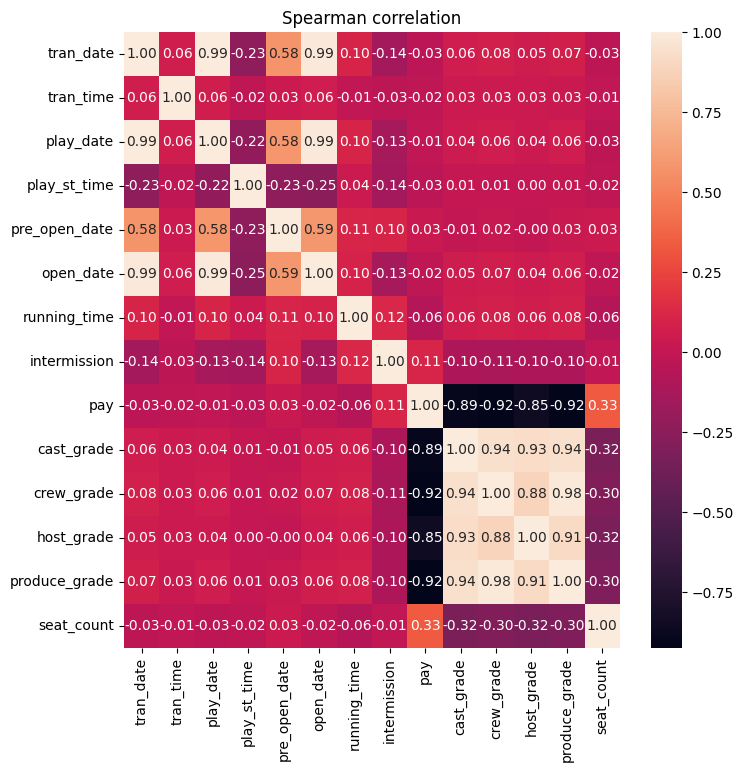

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8 ,8))  # 히트맵의 크기를 조정합니다.
sns.heatmap(cor, annot=True, fmt='.2f')
plt.title('Spearman correlation')  # 히트맵 제목 설정
plt.show()

In [ ]:
weak = []
strong = []
cor_col = list(cor.columns)
for i in range(len(cor)):
    for j in range(i+1,len(cor)):
        if abs(cor.iloc[i,j]) >= 0.7:
            strong.append((cor_col[i],cor_col[j]))
        elif abs(cor.iloc[i,j])>=0.3:
            weak.append((cor_col[i],cor_col[j]))

In [ ]:
# 약한 상관관계를 가지는 경우
print(weak)

In [ ]:
# 강한 상관관계를 가지는 경우
print(strong)

- ['tran_date','open_date','crew_grade','host_grade','produce_grade'] 제거

In [ ]:
df3.drop(['tran_date','open_date','crew_grade','host_grade','produce_grade'],inplace=True,axis=1)

In [ ]:
col = list(df3.columns)
# 종속형 변수
cat = [c for c in col if c not in non_cat]

In [ ]:
non_cat = ['tran_time','play_date','play_st_time','pre_open_date','running_time','intermission','pay','cast_grade','seat_count']

In [ ]:
from tqdm import tqdm
from scipy.stats import chi2_contingency
import numpy as np
import warnings
warnings.filterwarnings( 'ignore' )

# 크래머 V계수를 저장할 딕셔너리 초기화
cramer_v_dict = {}
categorical_columns = df3[cat]
continAndOrdinal_columns = df3[non_cat]

# 두 명목변수 간의 크래머 V계수 계산 및 저장
for i in tqdm(range(len(categorical_columns.columns))):
    for j in range(len(continAndOrdinal_columns.columns)):
        cross_tab = pd.crosstab(categorical_columns.iloc[:, i], continAndOrdinal_columns.iloc[:, j])
        chi2, _, _, _ = chi2_contingency(cross_tab)
        n = cross_tab.sum().sum()
        k, r = cross_tab.shape
        v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
        cramer_v_dict[(categorical_columns.columns[i], continAndOrdinal_columns.columns[j])] = v

# 크래머 V계수 출력
for key, value in cramer_v_dict.items():
    print(f"Cramer's V between '{key[0]}' and '{key[1]}': {value}")

In [ ]:
for key, value in cramer_v_dict.items():
    if value >= 0.6:
        print(f"Cramer's V between '{key[0]}' and '{key[1]}': {value}")

In [ ]:
remove = ['play_st_time','play_date','pre_open_date']

In [ ]:
df4 = df3.drop(remove,axis=1)
df4.shape

(285877, 53)

In [ ]:
df4.columns

In [ ]:
cat = ['member_yn','gender_F', 'gender_M', 'gender_N','seat_prefer',
       'genre_가족극', 'genre_교향곡', 'genre_기타', 'genre_독주', 'genre_복합장르',
       'genre_성악', 'genre_실내악', 'genre_오페라', 'genre_재즈', 'genre_콘서트',
       'genre_크로스오버', 'genre_클래식', 'genre_합창', 'membership_2_N',
       'membership_2_경로', 'membership_2_공연예매권', 'membership_2_문화누리',
       'membership_2_장애및보훈', 'membership_2_학생', 'membership_2_후원회원',
       'membership_1_골드', 'membership_1_그린', 'membership_1_노블',
       'membership_1_블루', 'membership_1_비회원', 'membership_1_싹틔우미',
       'membership_1_일반', 'segment_멤버십소지자', 'segment_문화향유소외계층', 'segment_찐VIP',
       'segment_취향형성자', 'segment_할인혜택고객', 'seg_type_1', 'seg_type_2',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']

In [ ]:
# 크래머 V계수를 저장할 딕셔너리 초기화
cramer_v_dict = {}
categorical_columns = df4[cat]

# 두 명목변수 간의 크래머 V계수 계산 및 저장
for i in tqdm(range(len(categorical_columns.columns))):
    for j in range(i+1, len(categorical_columns.columns)):
        cross_tab = pd.crosstab(categorical_columns.iloc[:, i], categorical_columns.iloc[:, j])
        chi2, _, _, _ = chi2_contingency(cross_tab)
        n = cross_tab.sum().sum()
        k, r = cross_tab.shape
        v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
        cramer_v_dict[(categorical_columns.columns[i], categorical_columns.columns[j])] = v

# 크래머 V계수 출력
for key, value in cramer_v_dict.items():
    print(f"Cramer's V between '{key[0]}' and '{key[1]}': {value}")

In [ ]:
for key, value in cramer_v_dict.items():
    if value >= 0.6:
        print(f"Cramer's V between '{key[0]}' and '{key[1]}': {value}")

In [ ]:
df4.drop(['gender_N' ,'membership_1_비회원','gender_M','membership_1_싹틔우미','membership_1_골드','membership_1_그린','membership_1_블루','membership_1_일반','seg_type_1'],axis=1,inplace=True)

## OLS

In [ ]:
import statsmodels.api as sm

In [ ]:
df4.columns

In [ ]:
x = df4.copy()
x = x.drop(['pay'],axis=1)

In [ ]:
x = sm.add_constant(x)
x.head()

In [ ]:
y = df4.pay.values
y[:5]

array([180000,  75000,  30000, 130000,  60000])

In [ ]:
model = sm.OLS(y, x)
result = model.fit()
print(result.summary())

In [ ]:
x = df4.copy()
x = x.drop(['pay','member_yn','play_weekend','seat_prefer','genre_가족극','membership_1_노블'],axis=1)

In [ ]:
x = sm.add_constant(x)
x.head()

In [ ]:
y = df4.pay.values
y[:5]

array([180000,  75000,  30000, 130000,  60000])

In [ ]:
model = sm.OLS(y, x)
result = model.fit()
print(result.summary())

In [ ]:
x = df4.copy()
x = x.drop(['pay','member_yn','play_weekend','seat_prefer','genre_가족극','membership_1_노블','genre_교향곡','genre_기타','genre_독주','genre_복합장르', 'genre_성악','genre_실내악','genre_오페라','genre_재즈','genre_콘서트','genre_크로스오버','genre_클래식','genre_합창','membership_2_문화누리'],axis=1)

In [ ]:
x = sm.add_constant(x)
x.head()

In [ ]:
y = df4.pay.values
y[:5]

array([180000,  75000,  30000, 130000,  60000])

In [ ]:
model = sm.OLS(y, x)
result = model.fit()
print(result.summary())

In [ ]:
x = df4.copy()
x = x.drop(['pay','member_yn','play_weekend','seat_prefer','genre_가족극','membership_1_노블','genre_교향곡','genre_기타','genre_독주','genre_복합장르', 'genre_성악','genre_실내악','genre_오페라','genre_재즈','genre_콘서트','genre_크로스오버','genre_클래식','genre_합창','membership_2_문화누리','gender_F'],axis=1)

In [ ]:
x = sm.add_constant(x)
x.head()

In [ ]:
model = sm.OLS(y, x)
result = model.fit()
print(result.summary())

In [ ]:
result.params

const                 146826.936774
tran_time                 -0.788246
running_time              18.412522
intermission            -153.229570
pre_open_date_Y/N       3381.399472
play-preopen              50.561042
cast_grade            -50817.418427
seat_count                 6.974076
membership_2_N         23076.730296
membership_2_경로        19192.070869
membership_2_공연예매권     24088.104542
membership_2_장애및보훈     24476.455406
membership_2_학생        18039.689649
membership_2_후원회원      51232.792206
segment_멤버십소지자         28447.140046
segment_문화향유소외계층       29539.588880
segment_찐VIP           32019.554096
segment_취향형성자          29021.755299
segment_할인혜택고객         27798.898453
seg_type_2              1726.493534
cluster_0              30181.769532
cluster_1              31633.371887
cluster_2              28841.940990
cluster_3              29371.897839
cluster_4              26797.956526
dtype: float64

In [ ]:
result.params.sort_values(ascending=False,key=lambda x:abs(x))

const                 146826.936774
membership_2_후원회원      51232.792206
cast_grade            -50817.418427
segment_찐VIP           32019.554096
cluster_1              31633.371887
cluster_0              30181.769532
segment_문화향유소외계층       29539.588880
cluster_3              29371.897839
segment_취향형성자          29021.755299
cluster_2              28841.940990
segment_멤버십소지자         28447.140046
segment_할인혜택고객         27798.898453
cluster_4              26797.956526
membership_2_장애및보훈     24476.455406
membership_2_공연예매권     24088.104542
membership_2_N         23076.730296
membership_2_경로        19192.070869
membership_2_학생        18039.689649
pre_open_date_Y/N       3381.399472
seg_type_2              1726.493534
intermission            -153.229570
play-preopen              50.561042
running_time              18.412522
seat_count                 6.974076
tran_time                 -0.788246
dtype: float64

In [ ]:
df5= df4.drop(['member_yn','play_weekend','seat_prefer','genre_가족극','membership_1_노블','genre_교향곡','genre_기타','genre_독주','genre_복합장르', 'genre_성악','genre_실내악','genre_오페라','genre_재즈','genre_콘서트','genre_크로스오버','genre_클래식','genre_합창','membership_2_문화누리','gender_F'],axis=1)

In [ ]:
df5.to_csv('/content/drive/MyDrive/예술의전당/통계분석후데이터(코로나제거).csv')

# XGBoost

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/예술의전당/after_cluster_data_for_statistic.csv")
df.head()

In [ ]:
df = df[['gender','tran_date','tran_time','play_date','seat','play_st_time','ticket_cancel','performance_code','pre_open_date','open_date','genre','running_time','intermission','member_yn','play_weekday','play_weekend','membership_2','membership_1','pre_open_date_Y/N','play-preopen','segment','seg_type','cast_grade','crew_grade','host_grade','produce_grade','seat_count','seat_prefer','cluster','pay']]

In [ ]:
df.shape

(285877, 30)

# 변수 처리

In [ ]:
df.columns

In [ ]:
df.isnull().sum()

In [ ]:
df.gender.fillna('N',inplace=True)

In [ ]:
df.pre_open_date.fillna('N',inplace=True)

In [ ]:
df.genre.fillna('클래식',inplace=True)

In [ ]:
df.membership_2.fillna('N',inplace=True)

In [ ]:
df['play-preopen'].fillna(0,inplace=True)

In [ ]:
from datetime import datetime
import time

In [ ]:
def make_timedelta(date):
  try:
    return time.mktime(datetime.strptime(date,'%Y-%m-%d').timetuple())
  except:
    return 0

In [ ]:
df.head()

In [ ]:
df2 = df.copy()

In [ ]:
df2['tran_date'] = df2['tran_date'].apply(make_timedelta)

In [ ]:
df2['play_date'] = df2['play_date'].apply(make_timedelta)
df2['pre_open_date'] = df2['pre_open_date'].apply(make_timedelta)

In [ ]:
df2.head()

In [ ]:
import re

In [ ]:
def to_int(days):
  if days != 0:
    return int(re.search('\d+',days).group())
  else:
    return days


In [ ]:
df2['play-preopen'] = df2['play-preopen'].apply(to_int)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le_gender = LabelEncoder()
gender_label = le_gender.fit_transform(df2['gender'])

le_code = LabelEncoder()
code_label = le_code.fit_transform(df2['performance_code'])

le_seat = LabelEncoder()
seat_label = le_seat.fit_transform(df2['seat'])

le_genre = LabelEncoder()
genre_label = le_genre.fit_transform(df2['genre'])

le_weekday = LabelEncoder()
weekday_label = le_weekday.fit_transform(df2['play_weekday'])

le_membership2 = LabelEncoder()
membership2_label = le_membership2.fit_transform(df2['membership_2'])

le_membership1 = LabelEncoder()
membership1_label = le_membership1.fit_transform(df2['membership_1'])

le_segment = LabelEncoder()
segment_label = le_segment.fit_transform(df2['segment'])

le_seg_type = LabelEncoder()
seg_type_label = le_seg_type.fit_transform(df2['seg_type'])

le_member_yn = LabelEncoder()
member_yn_label = le_member_yn.fit_transform(df2['member_yn'])

le_weekend = LabelEncoder()
weekend_label = le_weekend.fit_transform(df2['play_weekend'])

le_pre_open_date_yn = LabelEncoder()
pre_open_date_yn_label = le_pre_open_date_yn.fit_transform(df2['pre_open_date_Y/N'])

le_cluster = LabelEncoder()
cluster_label = le_cluster.fit_transform(df2['cluster'])

In [ ]:
print('le_gender : ',le_gender.classes_)
print('le_code : ',le_code.classes_)
print('')
print('le_genre : ',le_genre.classes_)
print('le_weekday : ',le_weekday.classes_)
print('le_membership2 : ',le_membership2.classes_)
print('le_membership1 : ',le_membership1.classes_)
print('le_segment : ',le_segment.classes_)
print('le_seg_type : ',le_seg_type.classes_)
print('le_member_yn : ',le_member_yn.classes_)
print('le_weekend : ',le_weekend.classes_)
print('le_pre_open_date_yn : ',le_pre_open_date_yn.classes_)
print('le_pre_open_date_yn : ',le_cluster.classes_)

In [ ]:
le_seat.classes_[:100]

In [ ]:
df2['gender_label'] = gender_label
df2['code_label'] = code_label
df2['seat_label'] = seat_label
df2['genre_label'] = genre_label
df2['weekday_label'] = weekday_label
df2['membership2_label'] = membership2_label
df2['membership1_label'] = membership1_label
df2['segment_label'] = segment_label
df2['seg_type_label'] = seg_type_label
df2['member_yn_label'] = member_yn_label
df2['weekend_label'] = weekend_label
df2['pre_open_date_yn_label'] = pre_open_date_yn_label
df2['cluster_label'] = cluster_label

In [ ]:
df2 = df2.drop(['gender','seat','performance_code','genre','play_weekday','membership_2','membership_1','segment','seg_type','member_yn','play_weekend','pre_open_date_Y/N','cluster'],axis=1)
df2.head()

In [ ]:
df2.columns

In [ ]:
df2.drop(['ticket_cancel'],axis=1,inplace=True)

In [ ]:
df2.to_csv('/content/drive/MyDrive/예술의전당/XGBoost.csv')